In [3]:
from sympy import *
import sympy as sp
import numpy as np
init_printing()
# get symbols quaternion
q0,q1,q2,q3 = symbols('q_0 q_1 q_2 q_3')
s_,x_,y_,z_ = symbols('s x y z')
# get symbols for displacement
dx,dy,dz = symbols('d_x d_y d_z')

r00 = 1 - 2 * (y_ * y_ + z_ * z_)
r01 = 2 * (x_ * y_ - s_ * z_)
r02 = 2 * (x_ * z_ + s_ * y_)

r10 = 2 * (x_ * y_ + s_ * z_)
r11 = 1 - 2 * (x_ * x_ + z_ * z_)
r12 = 2 * (y_ * z_ - s_ * x_)

r20 = 2 * (x_ * z_ - s_ * y_)
r21 = 2 * (y_ * z_ + s_ * x_)
r22 = 1 - 2 * (x_ * x_ + y_ * y_)

R = Matrix([[r00, r01, r02],[r10, r11, r12],[r20, r21, r22]])
R = R.subs({s_:q0,x_:q1,y_:q2,z_:q3})
p = Matrix([dx,dy,dz])
H = Matrix(np.zeros((4,4)))
H[0:3,0:3] = R
H[0:3,3] = p
H[3,3] = 1
H

⎡      2       2                                                   ⎤
⎢- 2⋅q₂  - 2⋅q₃  + 1  -2⋅q₀⋅q₃ + 2⋅q₁⋅q₂    2⋅q₀⋅q₂ + 2⋅q₁⋅q₃   dₓ ⎥
⎢                                                                  ⎥
⎢                           2       2                              ⎥
⎢ 2⋅q₀⋅q₃ + 2⋅q₁⋅q₂   - 2⋅q₁  - 2⋅q₃  + 1  -2⋅q₀⋅q₁ + 2⋅q₂⋅q₃   d_y⎥
⎢                                                                  ⎥
⎢                                                2       2         ⎥
⎢-2⋅q₀⋅q₂ + 2⋅q₁⋅q₃    2⋅q₀⋅q₁ + 2⋅q₂⋅q₃   - 2⋅q₁  - 2⋅q₂  + 1  d_z⎥
⎢                                                                  ⎥
⎣         0                    0                    0            1 ⎦

In [4]:
# define helper functions
def read_data(filename):
    import csv
    rows = []
    x0_list = []
    x1_list = []
    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        # extracting each data row one by one
        for row in csvreader:
            # parse the number
            x0_this = np.zeros((4,1))
            x0_this[-1] = 1
            x1_this = np.zeros((4,1))
            x1_this[-1] = 1
            for k in range(6):
                if k<=2:
                    x0_this[k] = float(row[k])
                else:
                    x1_this[k-3] = float(row[k])
            x0_list.append(x0_this)
            x1_list.append(x1_this)
    return x0_list,x1_list

def sub_val(m,var):
    var = var.reshape((7,))
    out = N(m.subs( {q0:float(var[0]),q1:float(var[1]),q2:float(var[2]),q3:float(var[3]),\
                     dx:float(var[4]),dy:float(var[5]),dz:float(var[6])} ))
    return out

def gradient_descent(init,cost,grad,cons_grad,learning_rate, max_iter, tol,decay):
    steps = [init] # history tracking
    cost_hist = []
    var = init
    
    for i in range(max_iter):

        cost_this = sub_val(cost,var)
        cost_hist.append(cost_this)
        
        g = sub_val(grad,var)
        g = np.array(g,dtype=float)
        
        cons_g = sub_val(cons_grad,var)
        cons_g = np.array(cons_g,dtype=float)
        cons_g = cons_g / np.linalg.norm(cons_g) # normalize

        # remove the projection onto the constraint gradient
        g = g - np.dot(g.transpose(),cons_g).item()*cons_g
        diff = learning_rate*(1/(1+i*decay))*g
        
        if i%50==0:
            print("   Iter "+str(i))
            print(np.linalg.norm(diff))
            print(cost_this)

        if np.linalg.norm(diff)<tol:
            break    
        var = var - diff
        # additional normalize
        var[0:4] = var[0:4] / np.linalg.norm(var[0:4])
        
        steps.append(var) # history tracing
        
    return steps, var, diff, cost_hist

def demean_T(x_list):
    T = np.zeros((4,4))
    for i in range(4):
        T[i,i] = 1
    m = np.zeros((3,1))
    for x in x_list:
        for j in range(3):
            m[j]=m[j]+x[j]
    m = m/len(x_list)
    T[0,3] = -m[0]
    T[1,3] = -m[1]
    T[2,3] = -m[2]
    return T

In [5]:
H_opt_list = [] # the list of optimal H matrices
err_list = []
x0_list = []
x1_list = []
for idata in range(3):
    print('-------Dataset '+str(idata+1)+'-------')
    x0_all,x1_all = read_data('dataset'+str(idata+1)+'.csv')
    x0_list.append(x0_all)
    x1_list.append(x1_all)
    N0 = len(x0_all)
    
    # first get demean transform matrix
    T0 = demean_T(x0_all)
    T1 = demean_T(x1_all)

    # computes the cost function
    cost = Matrix([0])
    for j in range(N0):
        #x0 = Matrix(x0_all[j].reshape((4,1)))
        #x1 = Matrix(x1_all[j].reshape((4,1)))
        x0 = Matrix( T0.dot(x0_all[j].reshape((4,1)))  ) # apply demean transformation
        x1 = Matrix( T1.dot(x1_all[j].reshape((4,1)))  ) # apply demean transformation
        cost = cost + x0.T*H.T*H*x0-2*x1.T*H*x0 + x1.T*x1
        cost = simplify(cost)
    cost = cost.det()/N0

    # compute gradient
    grad = cost.diff(Matrix([q0,q1,q2,q3,dx,dy,dz]))

    # compute constraint gradient, q0, q1, q2 and q3 needs to form a unit vector
    cons_grad = Matrix([2]) 

    # express the constraints
    constraint = q0*q0+q1*q1+q2*q2+q3*q3 - 1

    # compute constraint gradient, q0, q1, q2 and q3 needs to form a unit vector
    cons_grad = constraint.diff(Matrix([q0,q1,q2,q3,dx,dy,dz]))

    # now performs gradient descent to find q0-3 and dx-dz
    learning_rate = 0.1
    tol = 1e-5
    max_iter = 1000
    decay = 0
    q_init = np.random.randn(4)
    q_init = q_init / np.linalg.norm(q_init)
    d_init = np.random.randn(3)
    init = np.concatenate((q_init,d_init)).reshape((7,1))

    steps, var, diff, cost_hist = gradient_descent(init,cost, grad,cons_grad, learning_rate, max_iter, tol,decay)

    # check rotation matrix orthoganlity
    print('checking orthoganality of final H matrix, dataset '+str(idata+1))
    H_optimal = sub_val(H, var)
    for i in range(3):
        print(H_optimal[0:3,i].T*H_optimal[0:3,i])
    print(H_optimal[0:3,0].T*H_optimal[0:3,1])
    print(H_optimal[0:3,1].T*H_optimal[0:3,2])
    print(H_optimal[0:3,2].T*H_optimal[0:3,0])

    # explicitly calculates error
    err_sq = 0 # add norm square
    err = 0 # add only norm
    H_opt_hat = np.array(H_optimal,dtype=float)
    # undo the demean transformation
    H_opt = np.linalg.inv(T1).dot(H_opt_hat).dot(T0)
    for i in range(len(x0_all)):
        x0_ = x0_all[i]
        x1_ = x1_all[i]
        tmp = x1_ - H_opt.dot(x0_)
        tmp = np.linalg.norm(tmp.reshape((4,)))
        err = err + tmp
        tmp = tmp**2
        err_sq = err_sq + tmp
    err_sq = err_sq / len(x0_all)
    err = err / len(x0_all)
    err_list.append(err)
    
    H_opt_list.append(H_opt)
    print("")

-------Dataset 1-------
   Iter 0
0.1934412361667155
1.33468890093282
   Iter 50
0.0004144774488760659
7.39287451401865e-6
checking orthoganality of final H matrix, dataset 1
Matrix([[1.00000000000000]])
Matrix([[1.00000000000000]])
Matrix([[1.00000000000000]])
Matrix([[-1.66533453693773e-16]])
Matrix([[-6.79523711605290e-17]])
Matrix([[-8.64651232557190e-18]])

-------Dataset 2-------
   Iter 0
0.6124287469424164
9.95079116008004
   Iter 50
0.0011387766621200435
5.37151792369822e-5
checking orthoganality of final H matrix, dataset 2
Matrix([[1.00000000000000]])
Matrix([[1.00000000000000]])
Matrix([[1.00000000000000]])
Matrix([[1.11022302462516e-16]])
Matrix([[-5.20417042793042e-17]])
Matrix([[1.66533453693773e-16]])

-------Dataset 3-------
   Iter 0
0.26898338855116116
2.07126182971745
   Iter 50
0.006895726404366449
0.00553791053321670
   Iter 100
0.0007454202311105363
6.31639863397371e-5
   Iter 150
7.861040168435476e-05
7.02269782271170e-7
checking orthoganality of final H matrix,

In [6]:
def printM(expr, num_digits):
     return expr.xreplace({n.evalf() : n if type(n)==int else Float(n, num_digits) for n in expr.atoms(Number)}) 
# print H matrices dataset 1
printM(Matrix(H_opt_list[0]),4)

⎡0.6123   0.6124    0.5001    22.24⎤
⎢                                  ⎥
⎢0.3537   0.3535    -0.866    5.53 ⎥
⎢                                  ⎥
⎢-0.7071  0.7071  -0.0001194  16.2 ⎥
⎢                                  ⎥
⎣   0       0         0        1.0 ⎦

In [7]:
# print H matrices dataset 2
printM(Matrix(H_opt_list[1]),4)

⎡-0.183   -0.9539  -0.2379   1.24 ⎤
⎢                                 ⎥
⎢0.1831   -0.2709   0.945   0.5304⎥
⎢                                 ⎥
⎢-0.9659  0.1294   0.2242    1.2  ⎥
⎢                                 ⎥
⎣   0        0        0      1.0  ⎦

In [17]:
# print H matrices dataset 3
printM(Matrix(H_opt_list[2]),4)

⎡0.4083   -0.814  0.4131   13.24 ⎤
⎢                                ⎥
⎢0.8753   0.4775  0.07592   2.53 ⎥
⎢                                ⎥
⎢-0.2591  0.3306  0.9075   0.1998⎥
⎢                                ⎥
⎣   0       0        0      1.0  ⎦

In [9]:
# print errors
print(err_list)

[5.453760956262393e-05, 0.0004888260689176684, 8.628829213433255e-05]


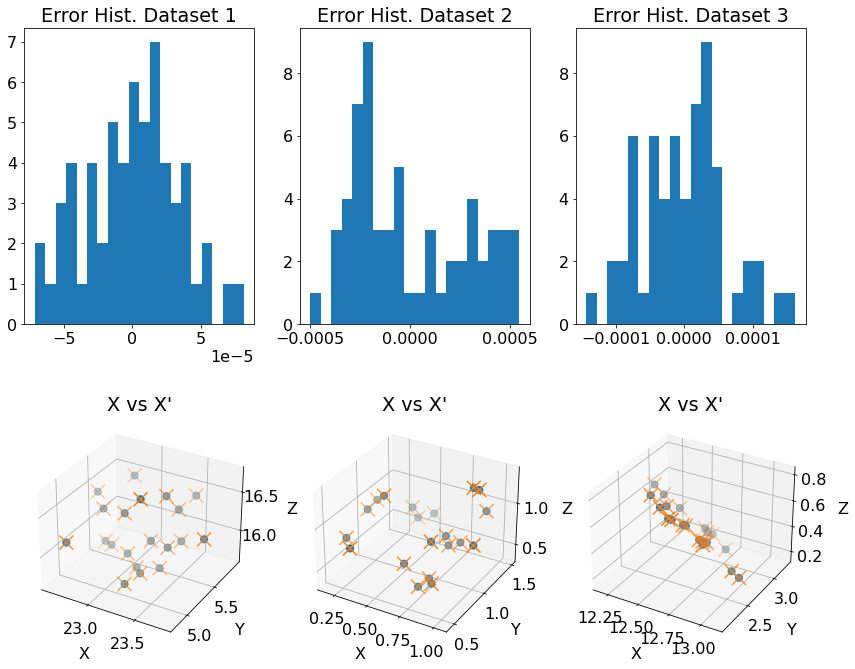

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,12))
plt.rc('font',size=16)
# try figure out the error distribution
for idata in range(3):
    x0_all = x0_list[idata]
    x1_all = x1_list[idata]
    H_opt = H_opt_list[idata]
    res_all = np.zeros((len(x0_all),3))
    xx = np.zeros((len(x0_all),6))
    for i in range(len(x0_all)):
        x0_ = x0_all[i]
        x1_ = x1_all[i]
        Hx0 = H_opt.dot(x0_)
        res = x1_ - Hx0
        res = res[0:3,:]
        res_all[i,:] = res.reshape((1,3))
        xx[i,0:3] = x1_[0:3].reshape((1,3))
        xx[i,3:6] = Hx0[0:3].reshape((1,3))
    plt.subplot(2,3,idata+1)
    plt.hist(res_all.reshape((len(x0_all)*3,)),20)
    plt.title("Error Hist. Dataset "+str(idata+1))
    # plot the point distributions

    ax = fig.add_subplot(230+idata+4,projection='3d')
    ax.scatter(xx[:,0], xx[:,1], xx[:,2], marker='o',s=50)
    ax.scatter(xx[:,3], xx[:,4], xx[:,5], marker='x',s=200)
    ax.set_xlabel('X',labelpad=10)
    ax.set_ylabel('Y',labelpad=10)
    ax.set_zlabel('Z',labelpad=10)
    plt.title("X vs X'")